## Imports

In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import tqdm

from transformers import ASTFeatureExtractor
from transformers import ASTForAudioClassification


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

save = Path('.').expanduser().absolute()
path = save / "state"
path2 = save / "state2"

embedding_path = save / "embedding"
targets_path = save / "targets"

data_path = save / "data"

test_data_path = save / "data"

cuda:0


## Loading GZTAN Data 

In [3]:
feature_extractor = ASTFeatureExtractor()

GENRES = ["metal", "disco", "rock", "pop", "country", "hiphop", "blues", "reggae", "jazz", "classical"]
GENRE_KEYS = {"metal" : 0, "disco" : 1, "rock" : 2, "pop" : 3, "country" : 4, "hiphop" : 5, "blues" : 6, "reggae" : 7, "jazz" : 8, "classical" : 9}

A = None
b = None

for genre in GENRES:
    i = 0
    while i < 100:
        filepath = "Data/genres_original/"+ genre + "/" + genre + ".000"
        if i < 10:
            filepath += "0"
        filepath += str(i) + ".wav"

        try:
            waveform, _ = torchaudio.load(filepath)
            waveform = waveform.squeeze().numpy()
            inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt") 
            input_values = inputs.input_values

            # Constructing data tensor
            
            if A is None:
                A = input_values
            else:
                A = np.concatenate((A, input_values), axis = 0)

            # Constructing target tensor

            if b is None:
                b = torch.tensor([GENRE_KEYS[genre]])
            else:
                b = np.concatenate((b, [GENRE_KEYS[genre]]), axis = 0)
        
        except RuntimeError:
            print("Skipping this " + filepath)
        i += 1
    print("Finished " + genre)

Finished metal
Finished disco
Finished rock
Finished pop
Finished country
Finished hiphop
Finished blues
Finished reggae
Skipping this Data/genres_original/jazz/jazz.00054.wav
Finished jazz
Finished classical


In [11]:
X = torch.from_numpy(A)
X = X.float()
X = X.to(device)

y = torch.from_numpy(b)
y = y.long()
y = y.to(device)

data = TensorDataset(X, y)

torch.save(data, data_path)

In [45]:
data = torch.load(data_path)

train_data, test_data = random_split(data, [899, 100])

In [46]:
batch_size = 12

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_loader = DataLoader(test_data, batch_size = 4, shuffle = True)

In [47]:
for x in train_loader:
    print(x[0].shape)
    print(x[0].is_cuda)
    break

torch.Size([12, 1024, 128])
True


# Building the Model

## Neural Networks

### MLP

Deep network consisting of fully connected layers and ReLU activation. We will use the second to last layer of this network for the latent em

In [4]:
class FullyConnectedNet(nn.Module):
  def __init__(self, in_features = 527, h1 = 128, h2 = 64, h3 = 64, h4 = 10, out_features = 10, p = 0):
    super().__init__()

    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, h4)
    self.fc5 = nn.Linear(h4, out_features)
    self.dropout = nn.Dropout(p)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    out = x
    x = self.fc5(x)

    return x, out

### Hybrid

This is a combination of a pre-trained neural network and the MLP. 

In [5]:
class Hybrid(nn.Module):
    def __init__(self, p = 0):
        super().__init__()
        self.MLP = FullyConnectedNet(p = p)
        self.AST = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

    def forward(self, x):
        x = self.AST(x)[0]
        x, _ = self.MLP.forward(x)

        return x

    def hidden(self, x):
        x = self.AST(x)[0]
        _, out = self.MLP.forward(x)

        return out

### Test and Train Functions

In [34]:
def train(model, train_loader, optimizer, criterion, epochs):
    loop = tqdm.tqdm(range(1, epochs + 1))

    train_losses = []
    train_accuracies = []
    
    for epoch in loop:
        train_accuracy, train_loss = train_epoch(model, train_loader, optimizer, criterion)

        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy)
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss.item(), train_accuracy=train_accuracy)

    return train_losses, train_accuracies

def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    loss = 0
    y_true_arr = None
    y_pred_arr = None

    for batch_idx, (data, target) in enumerate(train_loader):
        bs = data.shape[0]
        y_pred = model.forward(data)
        loss = criterion(y_pred, target)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        loss += loss.item() * bs
    
        if y_true_arr is None:
          y_true_arr = target.detach().cpu().numpy()
          y_pred_arr = y_pred.detach().cpu().numpy().argmax(axis = 1)
        else:
          y_true_arr = np.concatenate((y_true_arr, target.detach().cpu().numpy()), axis = 0)
          y_pred_arr = np.concatenate((y_pred_arr, y_pred.detach().cpu().numpy().argmax(axis = 1)), axis = 0)

    acc = accuracy_score(y_true_arr, y_pred_arr)
    loss = loss / len(train_loader.dataset)

    print(y_pred_arr[0 : 10])
    print(y_true_arr[0 : 10])

    return acc, loss

def test(model, test_loader, criterion):
    model.eval()
    loss = 0
    y_true_arr = None
    y_pre_arr = None
    
    for batch_idx, (data, target) in enumerate(test_loader):
        bs = data.shape[0]
        y_pred = model.forward(data)
        loss = criterion(y_pred, target)
    
        loss += loss.item() * bs
    
        if y_true_arr is None:
          y_true_arr = target.detach().cpu().numpy()
          y_pred_arr = y_pred.detach().cpu().numpy().argmax(axis = 1)
        else:
          y_true_arr = np.concatenate((y_true_arr, target.detach().cpu().numpy()), axis = 0)
          y_pred_arr = np.concatenate((y_pred_arr, y_pred.detach().cpu().numpy().argmax(axis = 1)), axis = 0)

    acc = accuracy_score(y_true_arr, y_pred_arr)
    loss = loss / len(train_loader.dataset)
    return acc, loss


## Training the MLP

Trains the hybrid model but freezes the weights of the pretrained network.

In [12]:
model = Hybrid()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.MLP.parameters(), lr = 1e-4)

epochs = 50

train_losses, train_accuracies = train(model, train_loader, optimizer, criterion, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]/home/cpsc452_hhc39/.conda/envs/cpsc552/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1:   2%|▏         | 1/50 [01:14<1:00:48, 74.45s/it, train_accuracy=0.136, train_loss=0.0306]

[0 0 0 0 0 0 0 0 0 0]
[6 8 9 8 0 7 9 6 8 3]


Epoch 2:   4%|▍         | 2/50 [02:28<59:24, 74.26s/it, train_accuracy=0.188, train_loss=0.0282]  

[5 5 5 5 9 5 5 5 5 5]
[1 3 5 0 8 4 1 8 1 3]


Epoch 3:   6%|▌         | 3/50 [03:42<58:04, 74.14s/it, train_accuracy=0.227, train_loss=0.0291]

[9 5 0 9 0 0 9 0 9 0]
[4 1 3 1 0 0 9 1 4 1]


Epoch 4:   8%|▊         | 4/50 [04:56<56:48, 74.09s/it, train_accuracy=0.185, train_loss=0.0272]

[0 9 5 5 5 5 5 5 9 5]
[0 9 3 1 2 5 1 2 2 4]


Epoch 5:  10%|█         | 5/50 [06:10<55:32, 74.06s/it, train_accuracy=0.179, train_loss=0.0284]

[0 0 3 3 0 3 5 3 9 0]
[2 7 9 9 2 7 1 9 3 6]


Epoch 6:  12%|█▏        | 6/50 [07:24<54:18, 74.05s/it, train_accuracy=0.217, train_loss=0.0276]

[5 3 5 5 5 0 0 5 9 3]
[4 4 3 4 2 6 0 6 9 9]


Epoch 7:  14%|█▍        | 7/50 [08:38<53:03, 74.04s/it, train_accuracy=0.26, train_loss=0.0241] 

[5 4 5 5 5 5 4 5 4 5]
[7 0 3 7 7 7 2 2 6 1]


Epoch 8:  16%|█▌        | 8/50 [09:52<51:48, 74.02s/it, train_accuracy=0.274, train_loss=0.0227]

[4 4 4 9 4 5 9 5 3 4]
[1 6 6 8 6 3 7 4 3 6]


Epoch 9:  18%|█▊        | 9/50 [11:06<50:34, 74.02s/it, train_accuracy=0.276, train_loss=0.0221]

[5 4 4 9 9 4 5 4 5 4]
[5 4 2 8 9 0 1 0 1 4]


Epoch 10:  20%|██        | 10/50 [12:20<49:20, 74.02s/it, train_accuracy=0.307, train_loss=0.0238]

[3 4 9 4 9 4 4 5 5 5]
[6 0 9 4 9 0 4 3 5 7]


Epoch 11:  22%|██▏       | 11/50 [13:34<48:06, 74.02s/it, train_accuracy=0.331, train_loss=0.0259]

[5 8 5 9 4 4 5 4 5 4]
[5 8 3 9 0 3 5 4 5 0]


Epoch 12:  24%|██▍       | 12/50 [14:48<46:52, 74.02s/it, train_accuracy=0.382, train_loss=0.0225]

[4 4 0 4 8 4 9 4 5 9]
[4 0 6 0 8 1 9 0 1 8]


Epoch 13:  26%|██▌       | 13/50 [16:02<45:38, 74.02s/it, train_accuracy=0.415, train_loss=0.0189]

[4 1 4 4 4 1 1 1 5 4]
[7 1 1 2 2 4 5 7 5 4]


Epoch 14:  28%|██▊       | 14/50 [17:16<44:24, 74.02s/it, train_accuracy=0.454, train_loss=0.0224]

[4 1 6 9 3 1 5 1 5 1]
[2 1 6 9 3 7 3 5 5 7]


Epoch 15:  30%|███       | 15/50 [18:30<43:11, 74.03s/it, train_accuracy=0.484, train_loss=0.0222]

[3 4 0 5 3 1 5 5 8 6]
[4 2 6 3 3 1 1 1 8 2]


Epoch 16:  32%|███▏      | 16/50 [19:44<41:56, 74.02s/it, train_accuracy=0.513, train_loss=0.0185]

[9 4 0 3 5 8 5 9 5 5]
[9 0 0 8 1 9 7 9 7 1]


Epoch 17:  34%|███▍      | 17/50 [20:58<40:43, 74.03s/it, train_accuracy=0.508, train_loss=0.0187]

[8 4 5 0 8 9 5 8 0 0]
[9 3 5 2 9 9 1 8 0 0]


Epoch 18:  36%|███▌      | 18/50 [22:12<39:29, 74.04s/it, train_accuracy=0.508, train_loss=0.0186]

[4 4 9 9 5 0 4 0 8 5]
[2 2 9 9 3 6 0 0 8 5]


Epoch 19:  38%|███▊      | 19/50 [23:26<38:15, 74.04s/it, train_accuracy=0.541, train_loss=0.0194]

[5 3 3 3 5 9 6 5 4 6]
[5 2 4 3 5 8 6 5 0 6]


Epoch 20:  40%|████      | 20/50 [24:41<37:01, 74.05s/it, train_accuracy=0.566, train_loss=0.015] 

[3 4 5 0 0 9 5 0 9 4]
[4 1 7 4 4 9 5 0 9 3]


Epoch 21:  42%|████▏     | 21/50 [25:55<35:47, 74.05s/it, train_accuracy=0.586, train_loss=0.0185]

[1 7 5 3 3 8 3 9 6 8]
[7 7 5 8 3 6 4 9 4 8]


Epoch 22:  44%|████▍     | 22/50 [27:09<34:33, 74.06s/it, train_accuracy=0.592, train_loss=0.0184]

[5 5 6 4 6 8 0 8 6 1]
[7 5 4 4 4 8 6 8 2 1]


Epoch 23:  46%|████▌     | 23/50 [28:23<33:20, 74.08s/it, train_accuracy=0.582, train_loss=0.0182]

[0 0 1 4 8 4 4 3 5 2]
[6 0 1 2 8 2 4 3 5 4]


Epoch 24:  48%|████▊     | 24/50 [29:37<32:05, 74.07s/it, train_accuracy=0.586, train_loss=0.0199]

[9 8 3 9 0 0 0 5 6 0]
[9 8 3 9 0 0 0 3 6 4]


Epoch 25:  50%|█████     | 25/50 [30:51<30:51, 74.06s/it, train_accuracy=0.606, train_loss=0.0146]

[1 3 6 6 0 3 5 9 0 6]
[4 8 6 2 0 3 1 9 0 6]


Epoch 26:  52%|█████▏    | 26/50 [32:05<29:37, 74.05s/it, train_accuracy=0.588, train_loss=0.0143]

[0 3 3 9 1 0 1 5 9 1]
[6 3 3 9 1 2 1 5 9 1]


Epoch 27:  54%|█████▍    | 27/50 [33:19<28:22, 74.03s/it, train_accuracy=0.622, train_loss=0.00883]

[7 3 0 4 8 5 6 3 1 6]
[7 2 0 0 8 5 2 4 2 6]


Epoch 28:  56%|█████▌    | 28/50 [34:33<27:08, 74.02s/it, train_accuracy=0.588, train_loss=0.0129] 

[0 1 7 8 8 1 8 6 8 9]
[4 0 1 8 8 7 8 4 8 9]


Epoch 29:  58%|█████▊    | 29/50 [35:47<25:54, 74.02s/it, train_accuracy=0.607, train_loss=0.0148]

[2 8 9 5 0 7 6 6 8 3]
[4 8 9 5 0 5 6 4 8 1]


Epoch 30:  60%|██████    | 30/50 [37:01<24:40, 74.01s/it, train_accuracy=0.63, train_loss=0.0167] 

[0 6 8 6 0 5 3 6 6 9]
[4 6 8 6 2 3 3 4 4 9]


Epoch 31:  62%|██████▏   | 31/50 [38:15<23:26, 74.00s/it, train_accuracy=0.616, train_loss=0.00741]

[0 8 1 3 9 7 5 2 0 0]
[0 8 5 3 9 6 5 4 0 6]


Epoch 32:  64%|██████▍   | 32/50 [39:29<22:11, 73.99s/it, train_accuracy=0.618, train_loss=0.0166] 

[7 0 7 8 2 3 6 8 5 0]
[7 0 5 7 1 1 8 8 5 2]


Epoch 33:  66%|██████▌   | 33/50 [40:43<20:57, 73.98s/it, train_accuracy=0.624, train_loss=0.0103]

[0 6 0 4 2 1 0 7 3 0]
[1 6 5 1 4 7 6 7 7 2]


Epoch 34:  68%|██████▊   | 34/50 [41:57<19:43, 73.97s/it, train_accuracy=0.645, train_loss=0.0186]

[9 8 5 1 3 6 5 0 4 0]
[9 8 5 1 3 4 5 0 0 0]


Epoch 35:  70%|███████   | 35/50 [43:11<18:29, 73.96s/it, train_accuracy=0.65, train_loss=0.014]  

[7 0 5 5 9 1 2 5 0 0]
[7 2 5 7 9 1 6 1 0 2]


Epoch 36:  72%|███████▏  | 36/50 [44:25<17:15, 73.95s/it, train_accuracy=0.651, train_loss=0.0216]

[9 1 5 3 1 9 6 0 6 9]
[9 1 3 3 3 9 0 0 7 9]


Epoch 37:  74%|███████▍  | 37/50 [45:39<16:01, 73.95s/it, train_accuracy=0.644, train_loss=0.0123]

[8 7 0 7 5 0 7 0 5 5]
[8 7 2 7 5 0 5 0 5 5]


Epoch 38:  76%|███████▌  | 38/50 [46:53<14:47, 73.95s/it, train_accuracy=0.66, train_loss=0.00997]

[8 9 7 5 1 3 5 3 2 5]
[8 9 1 5 1 4 5 7 2 1]


Epoch 39:  78%|███████▊  | 39/50 [48:06<13:33, 73.96s/it, train_accuracy=0.673, train_loss=0.015] 

[5 7 6 4 0 0 0 8 6 7]
[5 7 6 4 2 0 7 8 2 7]


Epoch 40:  80%|████████  | 40/50 [49:20<12:19, 73.95s/it, train_accuracy=0.67, train_loss=0.0102]

[3 5 6 1 3 5 6 6 5 2]
[3 5 6 7 2 1 6 6 7 2]


Epoch 41:  82%|████████▏ | 41/50 [50:34<11:05, 73.95s/it, train_accuracy=0.666, train_loss=0.0136]

[9 5 5 0 7 5 4 5 7 4]
[9 5 5 0 7 5 4 1 7 0]


Epoch 42:  84%|████████▍ | 42/50 [51:48<09:51, 73.95s/it, train_accuracy=0.69, train_loss=0.0114] 

[8 7 2 3 5 9 6 8 9 0]
[8 7 2 1 7 9 6 9 9 0]


Epoch 43:  86%|████████▌ | 43/50 [53:02<08:37, 73.95s/it, train_accuracy=0.679, train_loss=0.00954]

[6 0 2 3 2 5 5 6 7 0]
[6 0 2 3 8 1 5 6 7 0]


Epoch 44:  88%|████████▊ | 44/50 [54:16<07:23, 73.95s/it, train_accuracy=0.675, train_loss=0.0162] 

[0 4 7 2 3 3 8 9 0 5]
[6 2 4 4 9 3 8 9 0 1]


Epoch 45:  90%|█████████ | 45/50 [55:30<06:09, 73.96s/it, train_accuracy=0.677, train_loss=0.0151]

[6 5 8 6 6 7 0 2 9 5]
[6 5 8 2 2 7 2 4 9 5]


Epoch 46:  92%|█████████▏| 46/50 [56:44<04:55, 73.96s/it, train_accuracy=0.709, train_loss=0.0129]

[6 6 0 9 0 5 6 7 8 9]
[6 6 0 9 2 1 6 7 8 9]


Epoch 47:  94%|█████████▍| 47/50 [57:58<03:41, 73.95s/it, train_accuracy=0.683, train_loss=0.0117]

[6 3 8 6 9 4 5 8 2 0]
[0 3 8 6 9 4 5 8 4 0]


Epoch 48:  96%|█████████▌| 48/50 [59:12<02:27, 73.96s/it, train_accuracy=0.694, train_loss=0.0134]

[4 1 5 3 3 2 9 4 3 7]
[1 5 5 1 3 2 9 2 7 7]


Epoch 49:  98%|█████████▊| 49/50 [1:00:26<01:13, 73.96s/it, train_accuracy=0.705, train_loss=0.0144]

[8 4 1 1 4 7 8 4 2 0]
[8 3 1 1 2 7 8 4 4 0]


Epoch 50: 100%|██████████| 50/50 [1:01:40<00:00, 74.01s/it, train_accuracy=0.709, train_loss=0.00772]

[0 1 6 4 7 1 0 7 1 5]
[0 1 6 4 7 1 0 7 3 1]


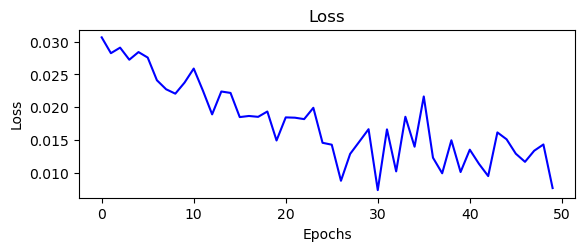

In [14]:
plt.subplot(2, 1, 1)
plt.plot(range(len(train_losses)), train_losses, color='b')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss");

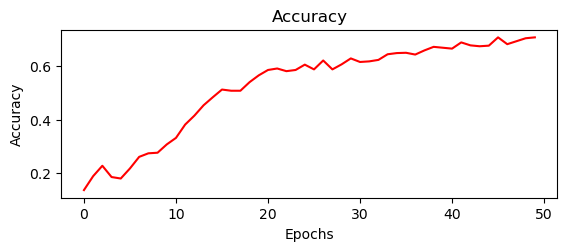

In [16]:
plt.subplot(2, 1, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, color='r')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy");

Saving this temporary version of the model:

In [17]:
torch.save(model.state_dict(), path)

In [6]:
model = Hybrid()
model.load_state_dict(torch.load(path))
model.to(device)

Hybrid(
  (MLP): FullyConnectedNet(
    (fc1): Linear(in_features=527, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=10, bias=True)
    (fc5): Linear(in_features=10, out_features=10, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (AST): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_feature

## Testing the MLP

In [18]:
criterion = nn.CrossEntropyLoss()
model.eval()
test(model, test_loader, criterion)

(0.73, tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>))

## Fine-tuning the Hybrid model

Updating the parameters of both the MLP and the pretrained network.

In [10]:
model = Hybrid(p = 0.1)
model.load_state_dict(torch.load(path))
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

epochs = 40

train_losses, train_accuracies = train(model, train_loader, optimizer, criterion, epochs)

  0%|          | 0/40 [00:00<?, ?it/s]/home/cpsc452_hhc39/.conda/envs/cpsc552/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1:   2%|▎         | 1/40 [01:13<48:03, 73.94s/it, train_accuracy=0.521, train_loss=0.0127]

[6 0 8 1 6 1 9 4 8 9]
[9 1 7 1 4 7 7 0 6 8]


Epoch 2:   5%|▌         | 2/40 [02:28<47:03, 74.29s/it, train_accuracy=0.67, train_loss=0.0158] 

[5 0 8 7 0 9 6 7 2 2]
[5 0 8 7 1 9 6 7 2 4]


Epoch 3:   8%|▊         | 3/40 [03:42<45:51, 74.37s/it, train_accuracy=0.707, train_loss=0.00815]

[5 6 5 3 0 3 0 5 8 4]
[7 6 5 4 4 1 0 5 8 1]


Epoch 4:  10%|█         | 4/40 [04:57<44:38, 74.40s/it, train_accuracy=0.741, train_loss=0.0103] 

[3 2 4 0 9 7 4 7 6 9]
[1 2 2 4 9 7 4 7 6 9]


Epoch 5:  12%|█▎        | 5/40 [06:11<43:25, 74.43s/it, train_accuracy=0.747, train_loss=0.0103]

[4 0 1 0 0 4 3 0 5 3]
[2 0 1 0 2 2 1 0 5 4]


Epoch 6:  15%|█▌        | 6/40 [07:26<42:10, 74.44s/it, train_accuracy=0.792, train_loss=0.00611]

[9 0 4 3 8 6 7 4 9 0]
[9 0 4 3 8 6 5 1 9 2]


Epoch 7:  18%|█▊        | 7/40 [08:40<40:56, 74.45s/it, train_accuracy=0.818, train_loss=0.00725]

[9 4 4 6 3 3 0 6 5 4]
[9 4 1 2 3 1 0 6 5 1]


Epoch 8:  20%|██        | 8/40 [09:55<39:42, 74.46s/it, train_accuracy=0.833, train_loss=0.00818]

[0 6 5 1 0 8 1 3 6 0]
[0 6 5 1 0 8 1 4 6 0]


Epoch 9:  22%|██▎       | 9/40 [11:09<38:28, 74.46s/it, train_accuracy=0.854, train_loss=0.00519]

[7 4 3 1 2 7 5 7 0 8]
[7 4 3 5 4 7 5 7 0 8]


Epoch 10:  25%|██▌       | 10/40 [12:24<37:13, 74.46s/it, train_accuracy=0.85, train_loss=0.00365]

[5 2 9 6 0 2 3 9 7 4]
[5 2 9 6 0 4 3 9 7 4]


Epoch 11:  28%|██▊       | 11/40 [13:38<35:59, 74.45s/it, train_accuracy=0.855, train_loss=0.00784]

[0 2 5 5 8 6 6 8 1 3]
[0 2 5 7 8 6 6 8 1 3]


Epoch 12:  30%|███       | 12/40 [14:53<34:44, 74.45s/it, train_accuracy=0.884, train_loss=0.00395]

[3 5 7 8 8 3 2 9 2 0]
[3 5 5 8 8 3 4 9 2 0]


Epoch 13:  32%|███▎      | 13/40 [16:07<33:30, 74.44s/it, train_accuracy=0.878, train_loss=0.00442]

[6 0 6 1 7 5 5 0 6 1]
[6 0 6 1 7 5 5 0 6 1]


Epoch 14:  35%|███▌      | 14/40 [17:21<32:15, 74.45s/it, train_accuracy=0.89, train_loss=0.00793] 

[8 0 4 2 6 4 8 0 6 8]
[8 0 4 2 6 4 8 0 6 8]


Epoch 15:  38%|███▊      | 15/40 [18:36<31:01, 74.45s/it, train_accuracy=0.907, train_loss=0.00312]

[2 7 8 4 5 8 7 3 4 5]
[2 7 8 2 5 8 7 4 2 5]


Epoch 16:  40%|████      | 16/40 [19:50<29:46, 74.45s/it, train_accuracy=0.912, train_loss=0.00159]

[8 5 2 8 8 1 5 0 4 5]
[8 5 4 8 8 1 5 0 4 5]


Epoch 17:  42%|████▎     | 17/40 [21:05<28:32, 74.46s/it, train_accuracy=0.925, train_loss=0.00197]

[8 0 4 7 6 0 7 7 5 0]
[8 0 4 7 6 0 7 7 1 0]


Epoch 18:  45%|████▌     | 18/40 [22:19<27:18, 74.47s/it, train_accuracy=0.91, train_loss=0.00538] 

[0 9 4 5 9 7 0 9 9 5]
[0 9 4 5 9 7 0 9 9 5]


Epoch 19:  48%|████▊     | 19/40 [23:34<26:04, 74.48s/it, train_accuracy=0.917, train_loss=0.00485]

[4 9 9 6 8 2 4 4 8 2]
[4 9 9 6 8 2 1 2 8 4]


Epoch 20:  50%|█████     | 20/40 [24:48<24:49, 74.48s/it, train_accuracy=0.919, train_loss=0.00328]

[2 7 5 6 2 8 8 8 5 9]
[2 7 5 6 2 8 8 8 5 9]


Epoch 21:  52%|█████▎    | 21/40 [26:03<23:35, 74.49s/it, train_accuracy=0.944, train_loss=0.00485]

[1 8 2 1 1 8 8 8 3 6]
[1 8 2 1 1 8 8 8 3 6]


Epoch 22:  55%|█████▌    | 22/40 [27:17<22:20, 74.48s/it, train_accuracy=0.947, train_loss=0.00275]

[0 0 8 6 9 1 5 7 5 2]
[0 0 8 6 9 1 1 7 5 2]


Epoch 23:  57%|█████▊    | 23/40 [28:32<21:06, 74.48s/it, train_accuracy=0.948, train_loss=0.00225]

[2 8 4 9 6 9 5 1 4 4]
[2 8 4 9 6 9 5 1 4 4]


Epoch 24:  60%|██████    | 24/40 [29:46<19:51, 74.47s/it, train_accuracy=0.947, train_loss=0.00265]

[4 6 5 0 7 2 9 9 5 4]
[4 6 5 0 7 2 9 9 5 4]


Epoch 25:  62%|██████▎   | 25/40 [31:01<18:37, 74.47s/it, train_accuracy=0.944, train_loss=0.00221]

[8 9 3 8 3 0 8 8 3 0]
[8 9 3 8 3 0 8 8 3 0]


Epoch 26:  65%|██████▌   | 26/40 [32:15<17:22, 74.48s/it, train_accuracy=0.939, train_loss=0.00529]

[3 0 0 2 8 7 2 4 2 2]
[3 0 0 2 8 7 2 2 2 2]


Epoch 27:  68%|██████▊   | 27/40 [33:30<16:08, 74.47s/it, train_accuracy=0.942, train_loss=0.00445]

[5 4 3 6 4 2 7 0 8 7]
[5 1 3 6 4 2 7 0 8 7]


Epoch 28:  70%|███████   | 28/40 [34:44<14:53, 74.48s/it, train_accuracy=0.954, train_loss=0.00441]

[7 1 0 8 3 2 9 5 6 3]
[7 1 0 8 4 4 9 5 6 3]


Epoch 29:  72%|███████▎  | 29/40 [35:59<13:39, 74.49s/it, train_accuracy=0.964, train_loss=0.00101]

[7 4 2 4 5 3 4 6 9 9]
[7 4 2 3 5 3 4 6 9 9]


Epoch 30:  75%|███████▌  | 30/40 [37:13<12:24, 74.48s/it, train_accuracy=0.96, train_loss=0.00283] 

[3 4 3 4 2 6 4 9 4 0]
[3 4 3 4 2 6 4 9 4 0]


Epoch 31:  78%|███████▊  | 31/40 [38:28<11:10, 74.48s/it, train_accuracy=0.971, train_loss=0.000806]

[0 2 9 3 4 8 3 8 1 4]
[0 2 9 3 4 8 3 8 1 4]


Epoch 32:  80%|████████  | 32/40 [39:42<09:55, 74.49s/it, train_accuracy=0.951, train_loss=0.00246] 

[9 3 7 1 2 2 0 9 0 2]
[9 3 7 1 2 2 0 9 0 2]


Epoch 33:  82%|████████▎ | 33/40 [40:57<08:41, 74.49s/it, train_accuracy=0.966, train_loss=0.00365]

[2 6 1 7 6 0 0 7 8 0]
[2 6 1 7 6 0 0 7 8 0]


Epoch 34:  85%|████████▌ | 34/40 [42:11<07:26, 74.48s/it, train_accuracy=0.961, train_loss=0.0086] 

[2 7 5 2 0 9 8 7 4 4]
[2 7 5 2 0 9 8 7 4 4]


Epoch 35:  88%|████████▊ | 35/40 [43:26<06:12, 74.49s/it, train_accuracy=0.967, train_loss=0.000539]

[0 6 5 2 1 1 8 2 2 1]
[0 6 5 2 4 1 8 2 2 4]


Epoch 36:  90%|█████████ | 36/40 [44:40<04:57, 74.49s/it, train_accuracy=0.971, train_loss=0.00273] 

[6 8 5 4 4 0 6 8 7 9]
[6 8 5 4 4 0 6 8 7 9]


Epoch 37:  92%|█████████▎| 37/40 [45:55<03:43, 74.49s/it, train_accuracy=0.969, train_loss=0.00111]

[1 6 9 4 4 8 3 6 5 2]
[4 6 9 4 4 8 3 6 5 2]


Epoch 38:  95%|█████████▌| 38/40 [47:09<02:28, 74.49s/it, train_accuracy=0.959, train_loss=0.00302]

[1 9 7 2 4 8 1 1 8 0]
[1 9 7 2 4 8 4 1 8 0]


Epoch 39:  98%|█████████▊| 39/40 [48:24<01:14, 74.49s/it, train_accuracy=0.97, train_loss=0.00128] 

[5 2 2 6 9 3 1 9 9 1]
[5 1 2 6 9 3 1 9 9 1]


Epoch 40: 100%|██████████| 40/40 [49:38<00:00, 74.46s/it, train_accuracy=0.969, train_loss=0.000734]

[2 4 6 7 7 3 6 7 9 3]
[2 4 6 7 7 3 6 7 9 3]


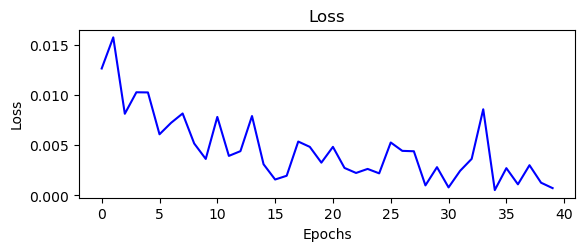

In [11]:
plt.subplot(2, 1, 1)
plt.plot(range(len(train_losses)), train_losses, color='b')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss");

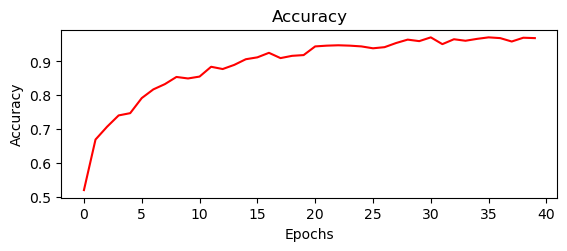

In [12]:
plt.subplot(2, 1, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, color='r')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy");

Saving the fine-tuned model. This is the final incarnation of the model. 

In [21]:
torch.save(model.state_dict(), path2)

In [7]:
model = Hybrid()
model.load_state_dict(torch.load(path2))
model.to(device)

Hybrid(
  (MLP): FullyConnectedNet(
    (fc1): Linear(in_features=527, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=10, bias=True)
    (fc5): Linear(in_features=10, out_features=10, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (AST): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_feature

### Testing the Fine-Tuned Model

In [13]:
criterion = nn.CrossEntropyLoss()
model.eval()
test(model, test_loader, criterion)

(0.88, tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>))

Just for fun, we imported some random examples to see how the classifier performed

In [20]:
IDX_KEYS = {0: "metal", 1 : "disco", 2 : "rock", 3 : "pop", 4 : "country", 5 : "hip hop", 6 : "blues", 7 : "reggae", 8 : "jazz", 9 : "classical"}

example0 = "Data/genres_original/metal/metal.00000.wav"
example1 = "Data/NicoRaccoon.wav"
example2 = "Data/Baba.wav"
example3 = "Data/NicologyChristmas.wav"
example4 = "Data/Ghost.wav"
example5 = "Data/FitterHappier.wav"


waveform, _ = torchaudio.load(example2)
waveform = waveform.squeeze().numpy()
            
inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt") 
input_values = inputs.input_values

print(input_values.shape)

input_values = input_values.to(device)


with torch.no_grad():
    outputs = model(input_values)

if outputs.shape[0] != 1:
    outputs = torch.unsqueeze(outputs[0], 0)
print(outputs)
IDX_KEYS[outputs.argmax(1).item()]


torch.Size([2, 1024, 128])
tensor([[ 1.2530,  2.7290,  0.7918, -1.4611,  2.2733,  0.5540, -2.0043, -1.8911,
         -7.4646, -8.9187]], device='cuda:0')


'disco'

# Data Analysis

## Saving Hidden Layer

We save the hidden (embedded) layer just so we don't need to load it each time.

In [ ]:
model.eval()

embedding = None
targets = None

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model.hidden(data)
        if embedding is None:
            embedding = output
        else:
            embedding = torch.cat((embedding, output), 0)
        if targets is None:
            targets = target
        else:
            targets = torch.cat((targets, target), 0)

In [49]:
print(embedding.detach().shape)
print(targets.detach().shape)

torch.save(embedding.cpu(), embedding_path)
torch.save(targets.cpu(), targets_path)

torch.Size([100, 10])
torch.Size([100])


In [35]:
embedding = torch.load(embedding_path)
targets = torch.load(targets_path)

In [21]:
!pip install --user --upgrade phate scprep
import phate

  Obtaining dependency information for phate from https://files.pythonhosted.org/packages/04/7e/85ea7d79b1150b08edcf5aac5bc6b601074f2b5cc43e8f3936b10d6e3b0a/phate-1.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for scprep from https://files.pythonhosted.org/packages/2a/d2/72a06c97668b07ef703ffdc392cbd5ce004733d14978f6ae2ae71a09df41/scprep-1.2.3-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=0.20.0 from https://files.pythonhosted.org/packages/4e/53/14405a47292b59235d811a2af8634aba188ccfd1a38ef4b8042f3447d79a/scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for future from https://files.pythonhosted.org/packages/da/71/ae30dadffc90b9006d77af76b393cb9dfbfc9629f339fc1574a1c52e6806/future-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for tasklogger>=1.2 from https://files.pythonhosted.org/packages/d6/f5/24855d6d8862ad03ae4dbb8f3ec06baf930a276c92af6

In [28]:
import scprep

In [41]:
by_neuron = embedding.T

# PHATE
Runs PHATE on the embeddings to get a 3-dimensional representation of the embeddings on the test set. Colors correspond to each genre; clusters are very tight and differentiated. Below the graph is a table of the color-genre correspondences.

Calculating PHATE...
  Running PHATE on 100 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 9
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.
Calculating metric MDS...
Calculated metric MDS in 0.02 seconds.


<Axes3D: xlabel='PHATE1', ylabel='PHATE2', zlabel='PHATE3'>

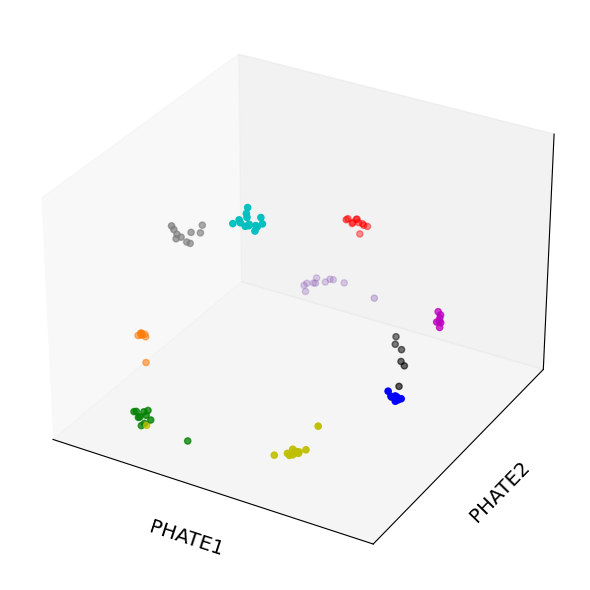

In [36]:
phate_operator = phate.PHATE(n_jobs=-2)

phate_operator.set_params(knn=40, decay=10) # better for test set
# phate_operator.set_params(knn=5, decay=40, t=12) # better for full set

Y_phate = phate_operator.fit_transform(embedding)

g = list(targets.detach().numpy())
cols = ['c', 'm', 'y', 'k', 'b', 'r', 'g', 'tab:gray', 'tab:orange', 'tab:purple']
colors = [cols[i] for i in g]

phate_operator.set_params(n_components=3)
Y_phate_3d = phate_operator.transform()

scprep.plot.scatter3d(Y_phate_3d, c=colors, figsize=(8,6),
                      ticks=False, label_prefix="PHATE")

In [37]:
print("GENRES: ")
GENRES = ["metal", "disco", "rock", "pop", "country", "hiphop", "blues", "reggae", "jazz", "classical"]
i = 0
while i < len(GENRES):
  if(GENRES[i] in ['country', 'classical']):
    print(GENRES[i], "\t", cols[i])
  else:
    print(GENRES[i], "\t\t", cols[i])
  i += 1

GENRES: 
metal 		 c
disco 		 m
rock 		 y
pop 		 k
country 	 b
hiphop 		 r
blues 		 g
reggae 		 tab:gray
jazz 		 tab:orange
classical 	 tab:purple


# Analysis by Neuron
Here we plot the same PHATE graph with the size of the point corresponding to the value of some particular Neuron (noted in the chart title). This allows us to see some information on which neurons are activated for which genres. Many of the weights are 0 for some neurons, which causes the points to disappear.

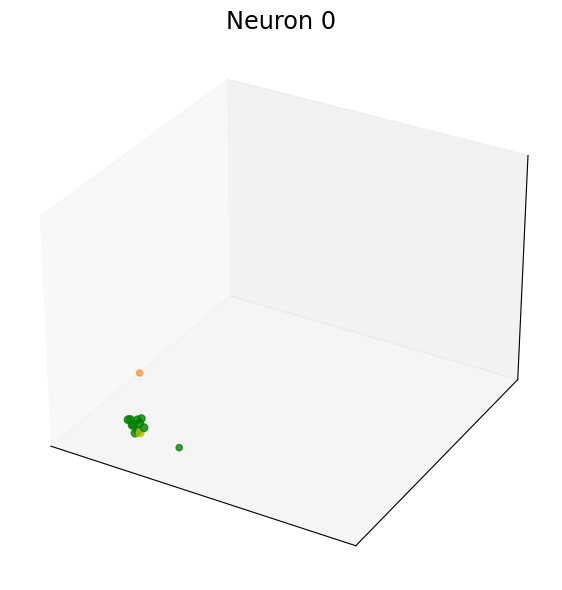

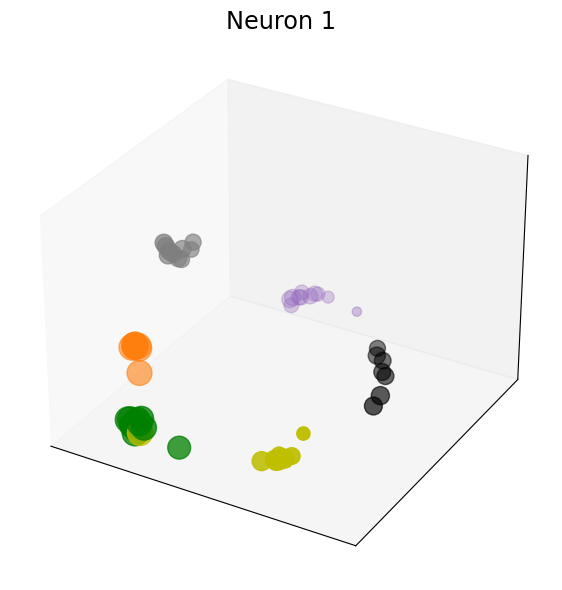

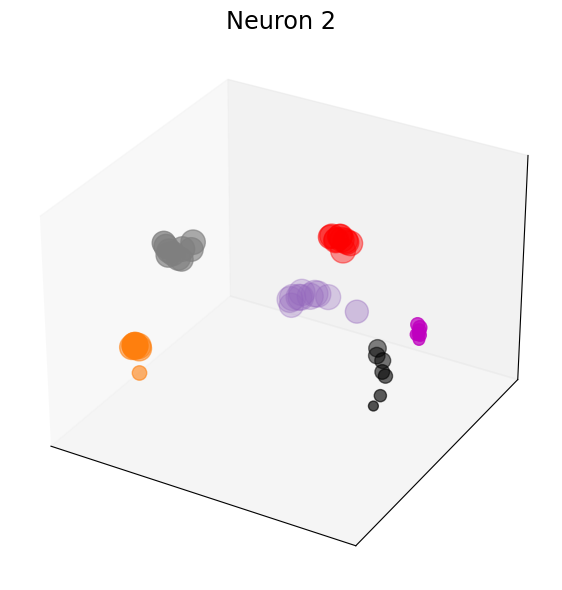

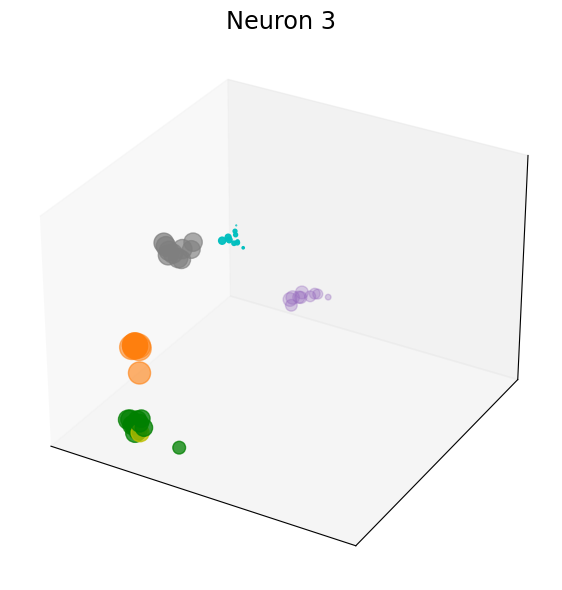

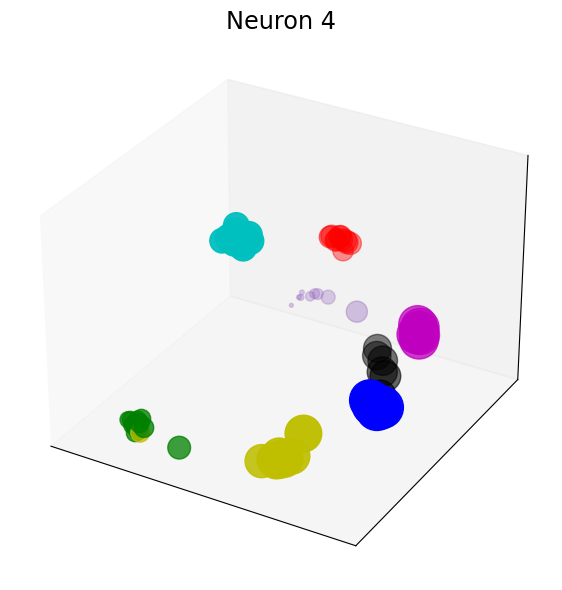

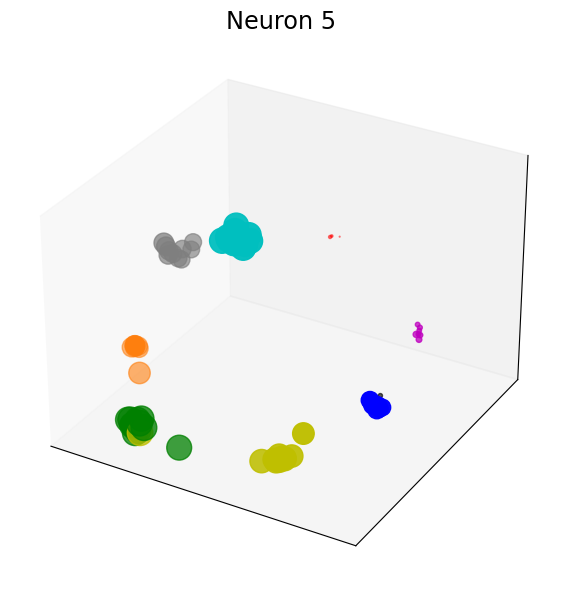

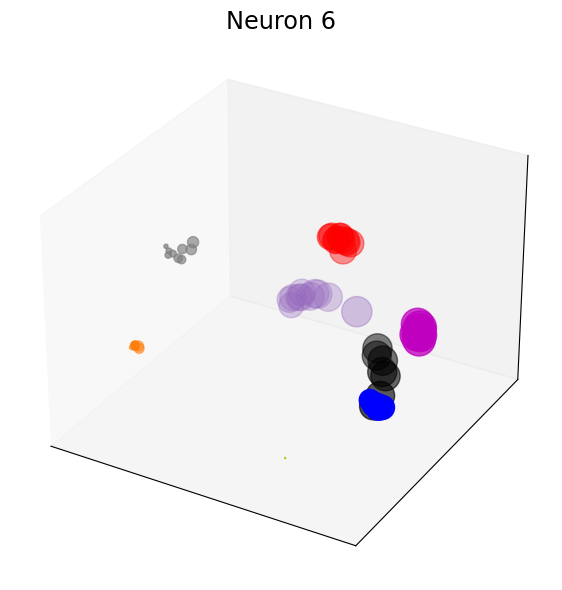

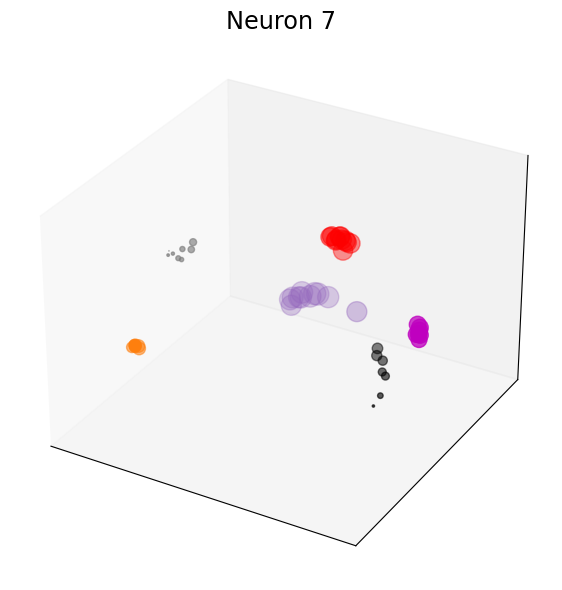

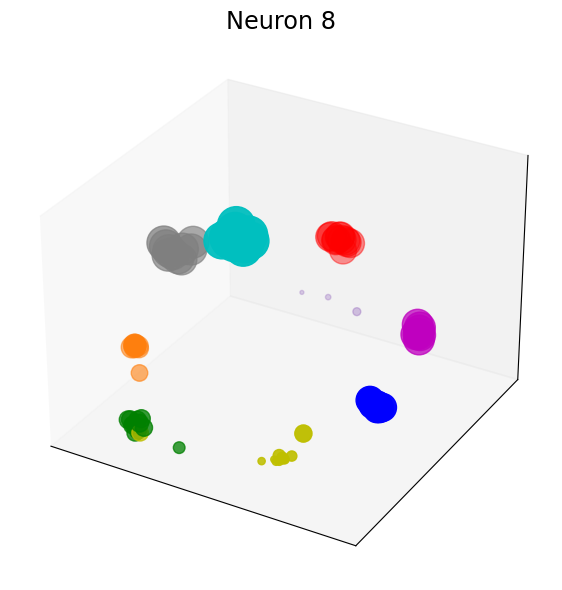

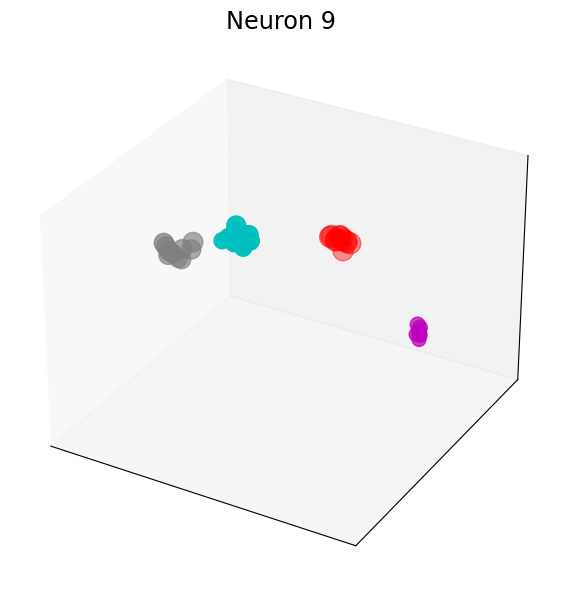

In [46]:
i = 0
for neuron_values in by_neuron:
  scprep.plot.scatter3d(Y_phate_3d, c=colors, figsize=(6,6), ticks=False, s=20*neuron_values, title="Neuron "+str(i))
  i += 1

Here we try to see if we can figure out what some of the neurons are representing directly. We remove one neuron at a time and identify points that are close together in all the other neurons. If the removed neuron was very different, we could listen to these two points and see what their difference is, and that would likely be related to what that neuron was encoding. But it turns out no two points really fit this qualification, so we did not end up using this kind of analysis.

In [47]:
def dist_without(v1, v2, targ):
  s = 0
  i = 0
  while i < len(v1):
    if i != targ:
      s += (v1[i] - v2[i]) ** 2
    i += 1
  return float(np.sqrt(s))

target_neuron = 9

rest_distances = []

i = 0
while i < len(embedding):
  j = 0
  rest_distances.append(list())
  while j < len(embedding):
    rest_distances[i].append(dist_without(embedding[i], embedding[j], target_neuron))
    j += 1
  i += 1

rd = np.array(rest_distances)

In [48]:
i = 0
while i < len(embedding):
  j = 0
  while j < len(embedding):
    if rd[i][j] <= 0.05 and rd[i][j] != 0:
      print(i, j, embedding[i][target_neuron], embedding[j][target_neuron], rd[i][j])
    j += 1
  i += 1

In [49]:
# Here we compute the mean of each neuron over each genre.
all_means = list()
for n in by_neuron:
  amts = [0] * 10
  sums = [0] * 10
  i = 0
  while i < len(n):
    amts[targets[i]] += 1
    sums[targets[i]] += n[i]
    i += 1
  i = 0
  means = list()
  while i < len(amts):
    means.append(float(sums[i] / amts[i]))
    if(means[i] > 0.05):
      print(GENRES[i])
    i += 1
  print(means)
  all_means.append(means)

rock
blues
jazz
[0.0, 0.0, 0.12889772653579712, 0.0, 0.0, 0.0, 1.4658561944961548, 0.0, 0.0977766290307045, 0.0]
rock
pop
blues
reggae
jazz
classical
[0.0, 0.0, 8.403240203857422, 7.57462215423584, 0.0, 0.0, 16.147798538208008, 7.362222194671631, 16.719764709472656, 5.481094837188721]
disco
pop
hiphop
reggae
jazz
classical
[0.0, 4.253407001495361, 0.0, 5.517519474029541, 0.0, 15.331765174865723, 0.0, 14.80870246887207, 15.009966850280762, 16.90760040283203]
metal
rock
blues
reggae
jazz
classical
[0.3725629448890686, 0.0, 0.6971666812896729, 0.0, 0.0, 0.0, 8.246610641479492, 9.330474853515625, 15.000577926635742, 3.1124937534332275]
metal
disco
rock
pop
country
hiphop
blues
classical
[17.29350471496582, 38.29866409301758, 30.22753143310547, 23.146026611328125, 44.44381332397461, 12.180769920349121, 8.63314151763916, 0.0, 0.0, 2.464172601699829]
metal
disco
rock
pop
country
blues
reggae
jazz
[16.06218147277832, 0.6976245045661926, 13.63941478729248, 0.20279879868030548, 7.724956512451172

In [52]:
# Getting ready to plot these averages
neurons = list()
weights = list()
targs = list()
cols2 = list()
i = 0
while i < 10:
  neurons.extend([i] * 10)
  weights.extend(all_means[i])
  targs.extend([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  cols2.extend(cols)
  i += 1

Here we plot different histograms for each neuron showing the average weight of that neuron for each of the ten genres, which does give us a pretty interesting picture of which neurons are responding to which genres.

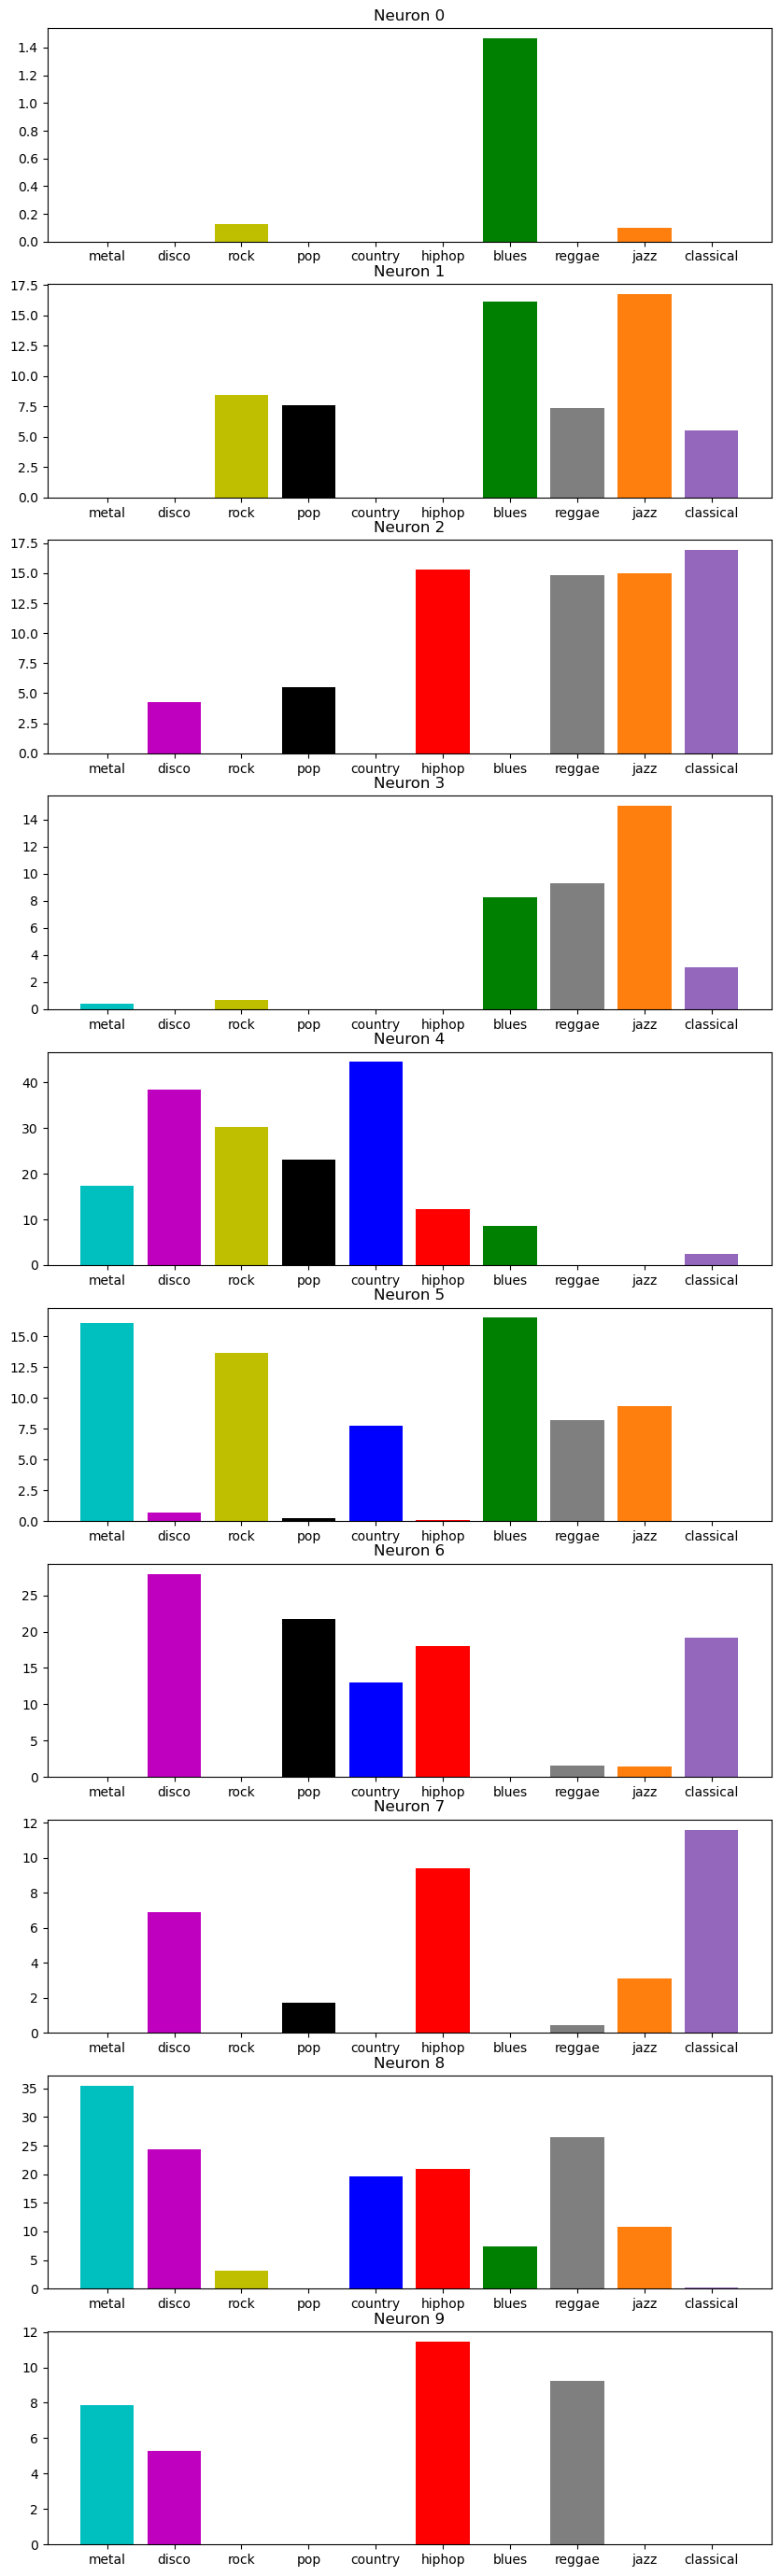

In [56]:
fig, axs = plt.subplots(10, 1, figsize=(10, 35))
axs_flat = axs.flatten()

i = 0
while i < 10:
  axs_flat[i].bar([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], all_means[i], tick_label=GENRES, color=cols)
  axs_flat[i].set_title("Neuron "+str(i))
  i += 1

Here we plot the whole test set over each pair of neurons, and see that even when selecting any two neurons we get pretty clear clusters for all of the genres.

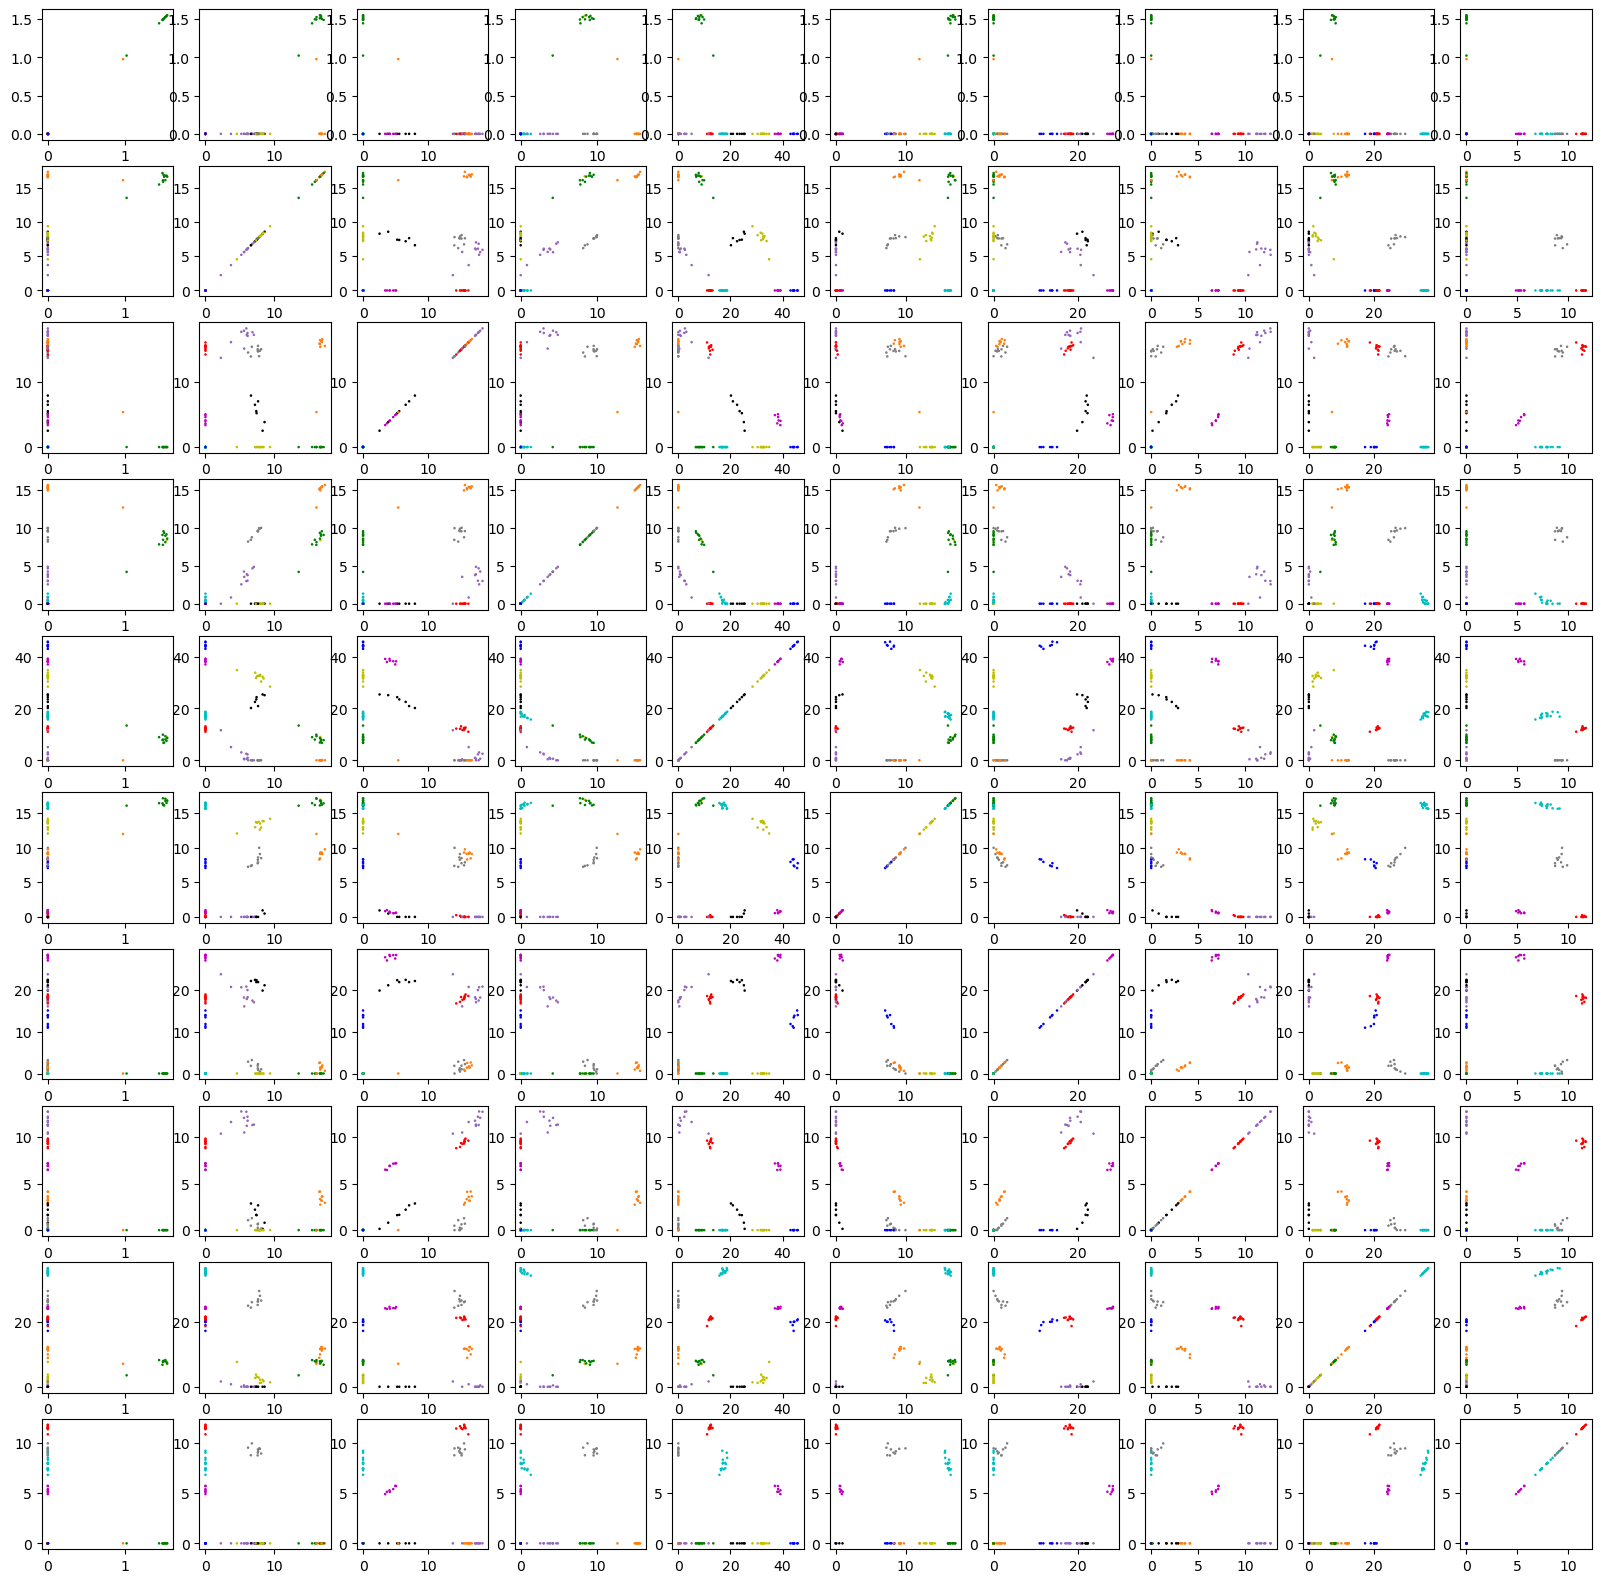

In [57]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
axs_flat = axs.flatten()

i = 0
j = 0
for ax in axs_flat:
  ax.scatter(by_neuron[i], by_neuron[j], c=colors, s=0.7)
  i += 1
  if i == 10:
    i = 0
    j += 1

## Speed, Volume, and Pitch Transformations

As described in our report, we apply a variety of speed, volume, and pitch transformations to the test data. We then see how the neuron activation for each neuron changes with respect to these transforms. The motivating idea is that some neurons might encode information related to speed, volume, and pitch, and by systematically analyzing the responses of the neuron activations, we can discover some of these relationships.

We first set up the dataloaders for each different transformation:

In [17]:
feature_extractor = ASTFeatureExtractor()

GENRES = ["metal", "disco", "rock", "pop", "country", "hiphop", "blues", "reggae", "jazz", "classical"]
GENRE_KEYS = {"metal" : 0, "disco" : 1, "rock" : 2, "pop" : 3, "country" : 4, "hiphop" : 5, "blues" : 6, "reggae" : 7, "jazz" : 8, "classical" : 9}

def vol_transform(gain):
    A = None
    b = None
    transform = torchaudio.transforms.Vol(gain = gain, gain_type = 'amplitude')
    
    for genre in GENRES:
        i = 0
        while i < 10:
            filepath = "Data/genres_original/"+ genre + "/" + genre + ".000"
            if i < 10:
                filepath += "0"
            filepath += str(i) + ".wav"
    
            try:
                waveform, _ = torchaudio.load(filepath)

                waveform = transform(waveform)
                
                waveform = waveform.squeeze().numpy()
                inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt") 
                input_values = inputs.input_values
    
                # Constructing data tensor
                
                if A is None:
                    A = input_values
                else:
                    A = np.concatenate((A, input_values), axis = 0)
    
                # Constructing target tensor
    
                if b is None:
                    b = torch.tensor([GENRE_KEYS[genre]])
                else:
                    b = np.concatenate((b, [GENRE_KEYS[genre]]), axis = 0)
            
            except RuntimeError:
                print("Skipping this " + filepath)
            i += 1
    X = torch.from_numpy(A)
    X = X.float()
    X = X.to(device)

    y = torch.from_numpy(b)
    y = y.long()
    y = y.to(device)

    data = TensorDataset(X, y)
    data_loader = DataLoader(data, batch_size = 4)
    return data_loader

def pitch_transform(n_steps):
    A = None
    b = None
    transform = torchaudio.transforms.PitchShift(sample_rate = 16000, n_steps = n_steps)
    
    for genre in GENRES:
        i = 0
        while i < 10:
            filepath = "Data/genres_original/"+ genre + "/" + genre + ".000"
            if i < 10:
                filepath += "0"
            filepath += str(i) + ".wav"
    
            try:
                waveform, _ = torchaudio.load(filepath)

                waveform = transform(waveform).detach()
                
                waveform = waveform.squeeze().numpy()
                inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt") 
                input_values = inputs.input_values
    
                # Constructing data tensor
                
                if A is None:
                    A = input_values
                else:
                    A = np.concatenate((A, input_values), axis = 0)
    
                # Constructing target tensor
    
                if b is None:
                    b = torch.tensor([GENRE_KEYS[genre]])
                else:
                    b = np.concatenate((b, [GENRE_KEYS[genre]]), axis = 0)
            
            except RuntimeError:
                print("Skipping this " + filepath)
            i += 1
    X = torch.from_numpy(A)
    X = X.float()
    X = X.to(device)

    y = torch.from_numpy(b)
    y = y.long()
    y = y.to(device)

    data = TensorDataset(X, y)
    data_loader = DataLoader(data, batch_size = 4)
    return data_loader

def speed_transform(factor):
    A = None
    b = None
    transform = torchaudio.transforms.Speed(orig_freq = 440, factor = factor)
    
    for genre in GENRES:
        i = 0
        while i < 10:
            filepath = "Data/genres_original/"+ genre + "/" + genre + ".000"
            if i < 10:
                filepath += "0"
            filepath += str(i) + ".wav"
    
            try:
                waveform, _ = torchaudio.load(filepath)
                waveform = transform(waveform)[0].detach()
                
                waveform = waveform.squeeze().numpy()
                inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt") 
                input_values = inputs.input_values
    
                # Constructing data tensor
                
                if A is None:
                    A = input_values
                else:
                    A = np.concatenate((A, input_values), axis = 0)
    
                # Constructing target tensor
    
                if b is None:
                    b = torch.tensor([GENRE_KEYS[genre]])
                else:
                    b = np.concatenate((b, [GENRE_KEYS[genre]]), axis = 0)
            
            except RuntimeError:
                print("Skipping this " + filepath)
            i += 1
    X = torch.from_numpy(A)
    X = X.float()
    X = X.to(device)

    y = torch.from_numpy(b)
    y = y.long()
    y = y.to(device)

    data = TensorDataset(X, y)
    data_loader = DataLoader(data, batch_size = 4)
    return data_loader


### Volume Transformations

In [70]:
means = None
all_embeddings = []
gains = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

for gain in gains:
    data_loader = vol_transform(gain)
    
    with torch.no_grad():
        embedding = None
        targets = None
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model.hidden(data)
            if embedding is None:
                embedding = output
            else:
                embedding = torch.cat((embedding, output), 0)
            if targets is None:
                targets = target
            else:
                targets = torch.cat((targets, target), 0)

    mean = torch.mean(embedding, dim = 0).cpu()
    mean = torch.unsqueeze(mean, 0)
    all_embeddings.append(embedding)
    if means is None:
        means = mean
    else:
        means = torch.cat((means, mean), 0)

print(means.shape)
by_neurons = means.T

torch.Size([10, 10])


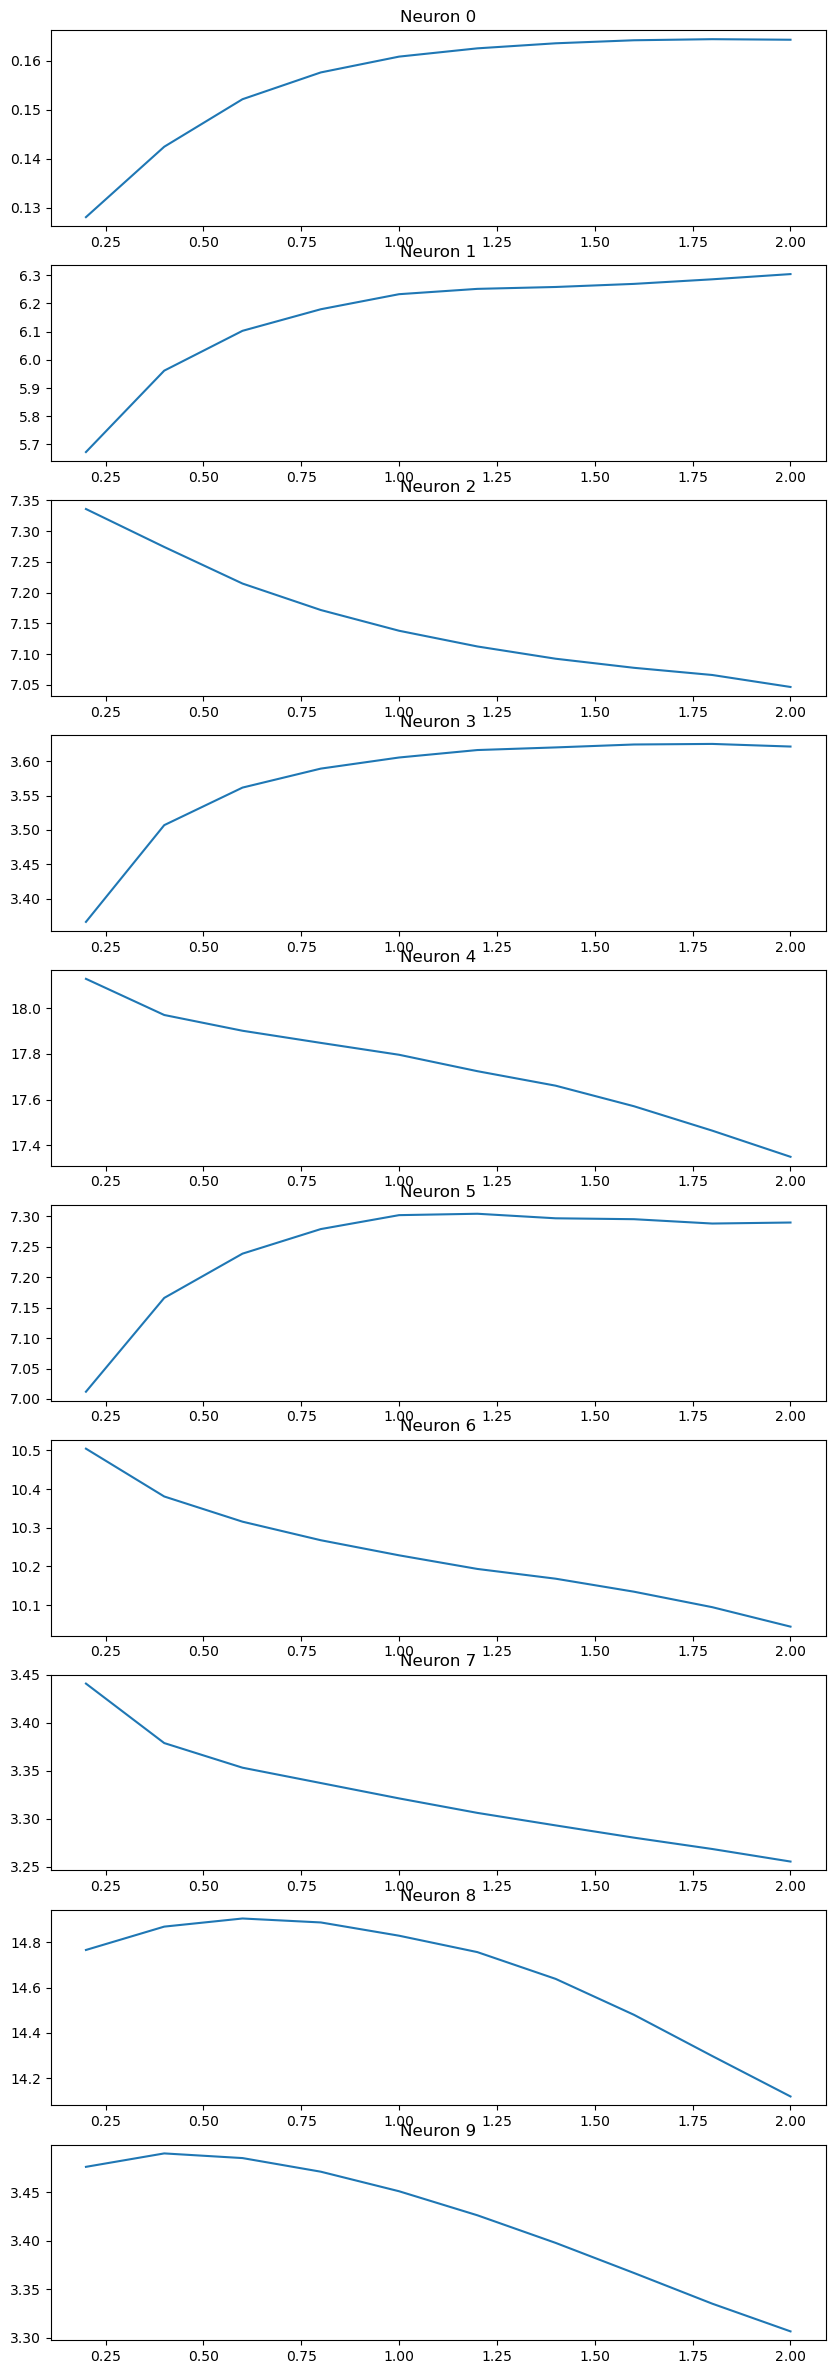

In [69]:
data = np.zeros((100,10,10))
targ = np.zeros((100,10))
sums_all = np.zeros((10,10))
i = 0
while i < len(all_embeddings[0]):
    j = 0
    while j < len(all_embeddings[0][0]):
        k = 0
        while k < len(all_embeddings):
            data[i][j][k] = all_embeddings[k][i][j]
            sums_all[j][k] += all_embeddings[k][i][j]
            k += 1
        targ[i][j] = targets[i]
        j += 1
    i += 1
#print(data, targ)

means_over_all = sums_all

# fig, axs = plt.subplots(10, figsize=(10, 30))
# i = 0
# for d in data:
#     j = 0
#     for c in d:
#         axs[j].plot(c)
#         j += 1
#     i += 1

fig, axs = plt.subplots(10, figsize=(10, 30))
i = 0
for m in means_over_all:
    axs[i].plot(gains, m / 100)
    axs[i].title.set_text("Neuron " + str(i))
    i += 1

### Pitch Transformations

In [78]:
means = None
all_embeddings = []
shifts = [-36, -24, -12, 0, 12, 24, 36]

for shift in shifts:
    data_loader = pitch_transform(shift)
    
    with torch.no_grad():
        embedding = None
        targets = None
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model.hidden(data)
            if embedding is None:
                embedding = output
            else:
                embedding = torch.cat((embedding, output), 0)
            if targets is None:
                targets = target
            else:
                targets = torch.cat((targets, target), 0)

    mean = torch.mean(embedding, dim = 0).cpu()
    mean = torch.unsqueeze(mean, 0)
    all_embeddings.append(embedding)
    if means is None:
        means = mean
    else:
        means = torch.cat((means, mean), 0)

print(means.shape)
by_neurons = means.T

torch.Size([7, 10])


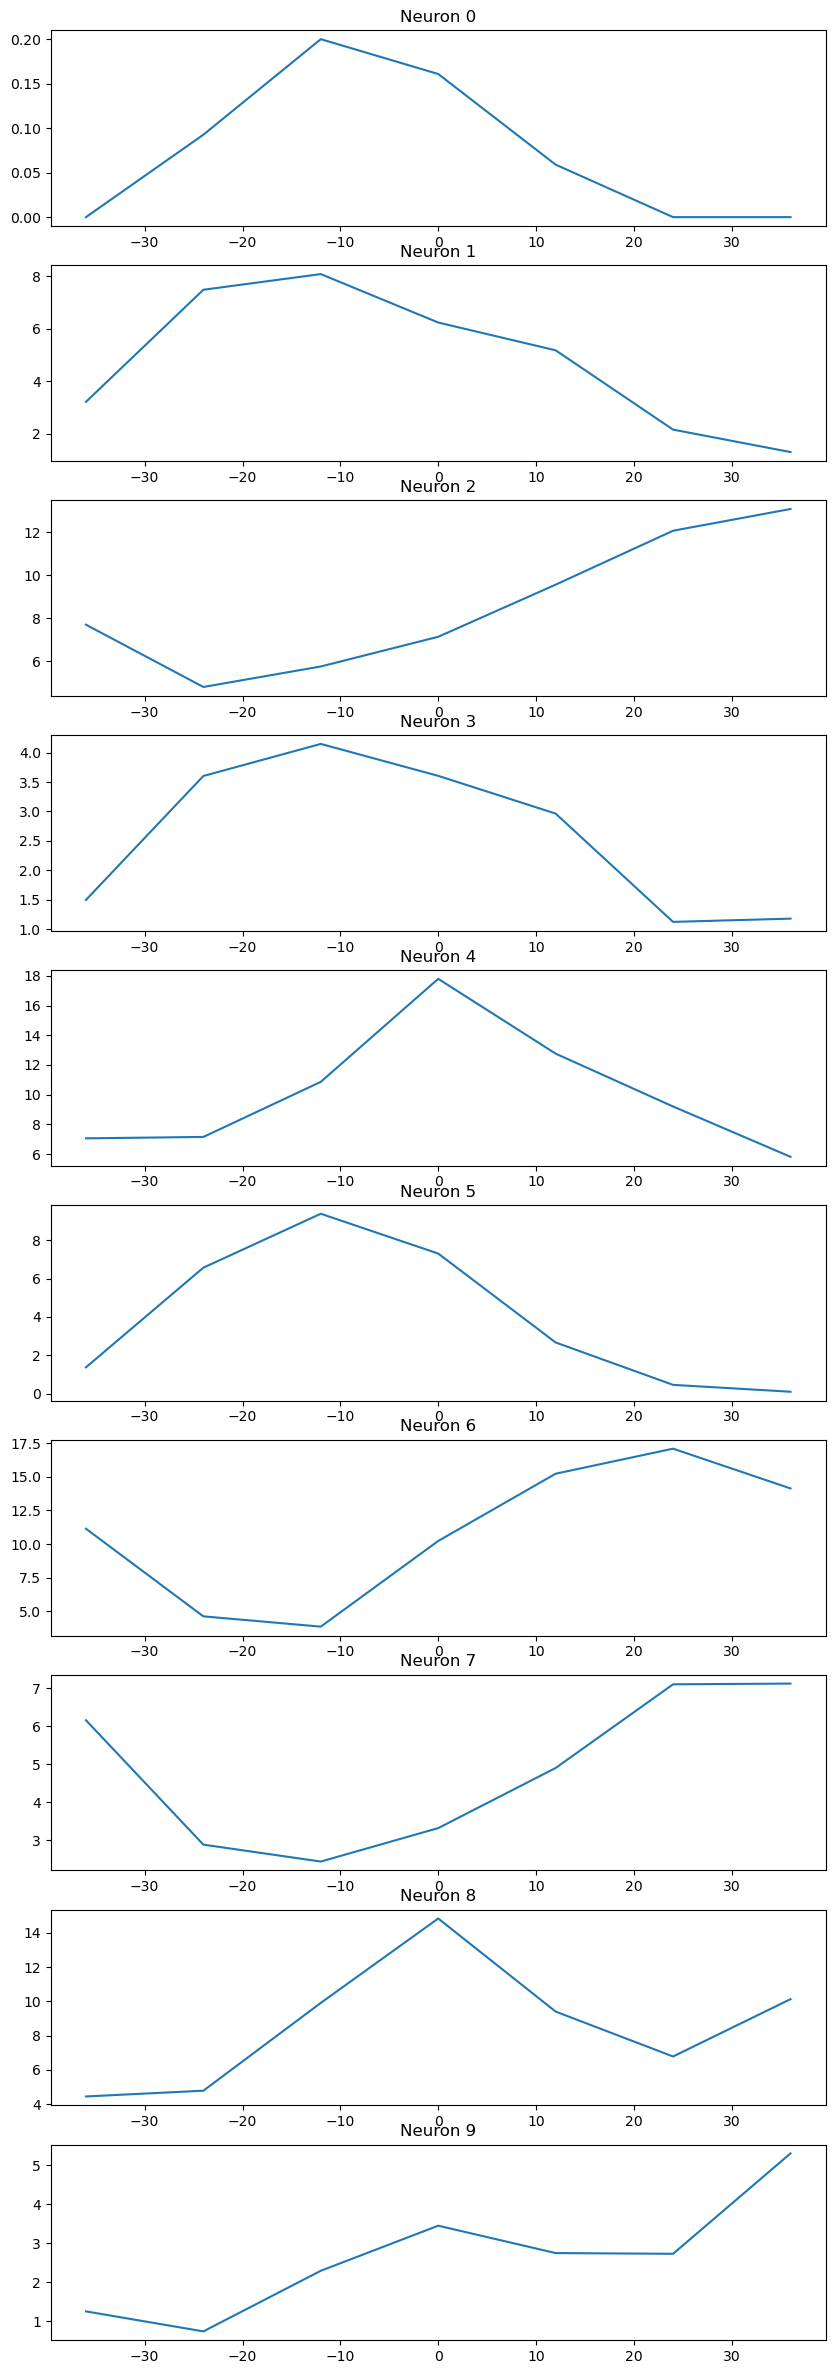

In [82]:
data = np.zeros((100,10,7))
targ = np.zeros((100,10))
sums_all = np.zeros((10,7))
i = 0
while i < len(all_embeddings[0]):
    j = 0
    while j < len(all_embeddings[0][0]):
        k = 0
        while k < len(all_embeddings):
            data[i][j][k] = all_embeddings[k][i][j]
            sums_all[j][k] += all_embeddings[k][i][j]
            k += 1
        targ[i][j] = targets[i]
        j += 1
    i += 1
#print(data, targ)

means_over_all = sums_all

# fig, axs = plt.subplots(10, figsize=(10, 30))
# i = 0
# for d in data:
#     j = 0
#     for c in d:
#         axs[j].plot(c)
#         j += 1
#     i += 1

fig, axs = plt.subplots(10, figsize=(10, 30))
i = 0
for m in means_over_all:
    axs[i].plot(shifts, m / 100)
    axs[i].title.set_text("Neuron " + str(i))
    i += 1

### Speed Transformations

In [18]:
means = None
all_embeddings = []
speeds = [0.5, 0.75, 1, 1.25, 1.5, 2]

for speed in speeds:
    data_loader = speed_transform(speed)
    
    with torch.no_grad():
        embedding = None
        targets = None
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model.hidden(data)
            if embedding is None:
                embedding = output
            else:
                embedding = torch.cat((embedding, output), 0)
            if targets is None:
                targets = target
            else:
                targets = torch.cat((targets, target), 0)

    mean = torch.mean(embedding, dim = 0).cpu()
    mean = torch.unsqueeze(mean, 0)
    all_embeddings.append(embedding)
    if means is None:
        means = mean
    else:
        means = torch.cat((means, mean), 0)

print(means.shape)
by_neurons = means.T

/home/cpsc452_hhc39/.conda/envs/cpsc552/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([6, 10])


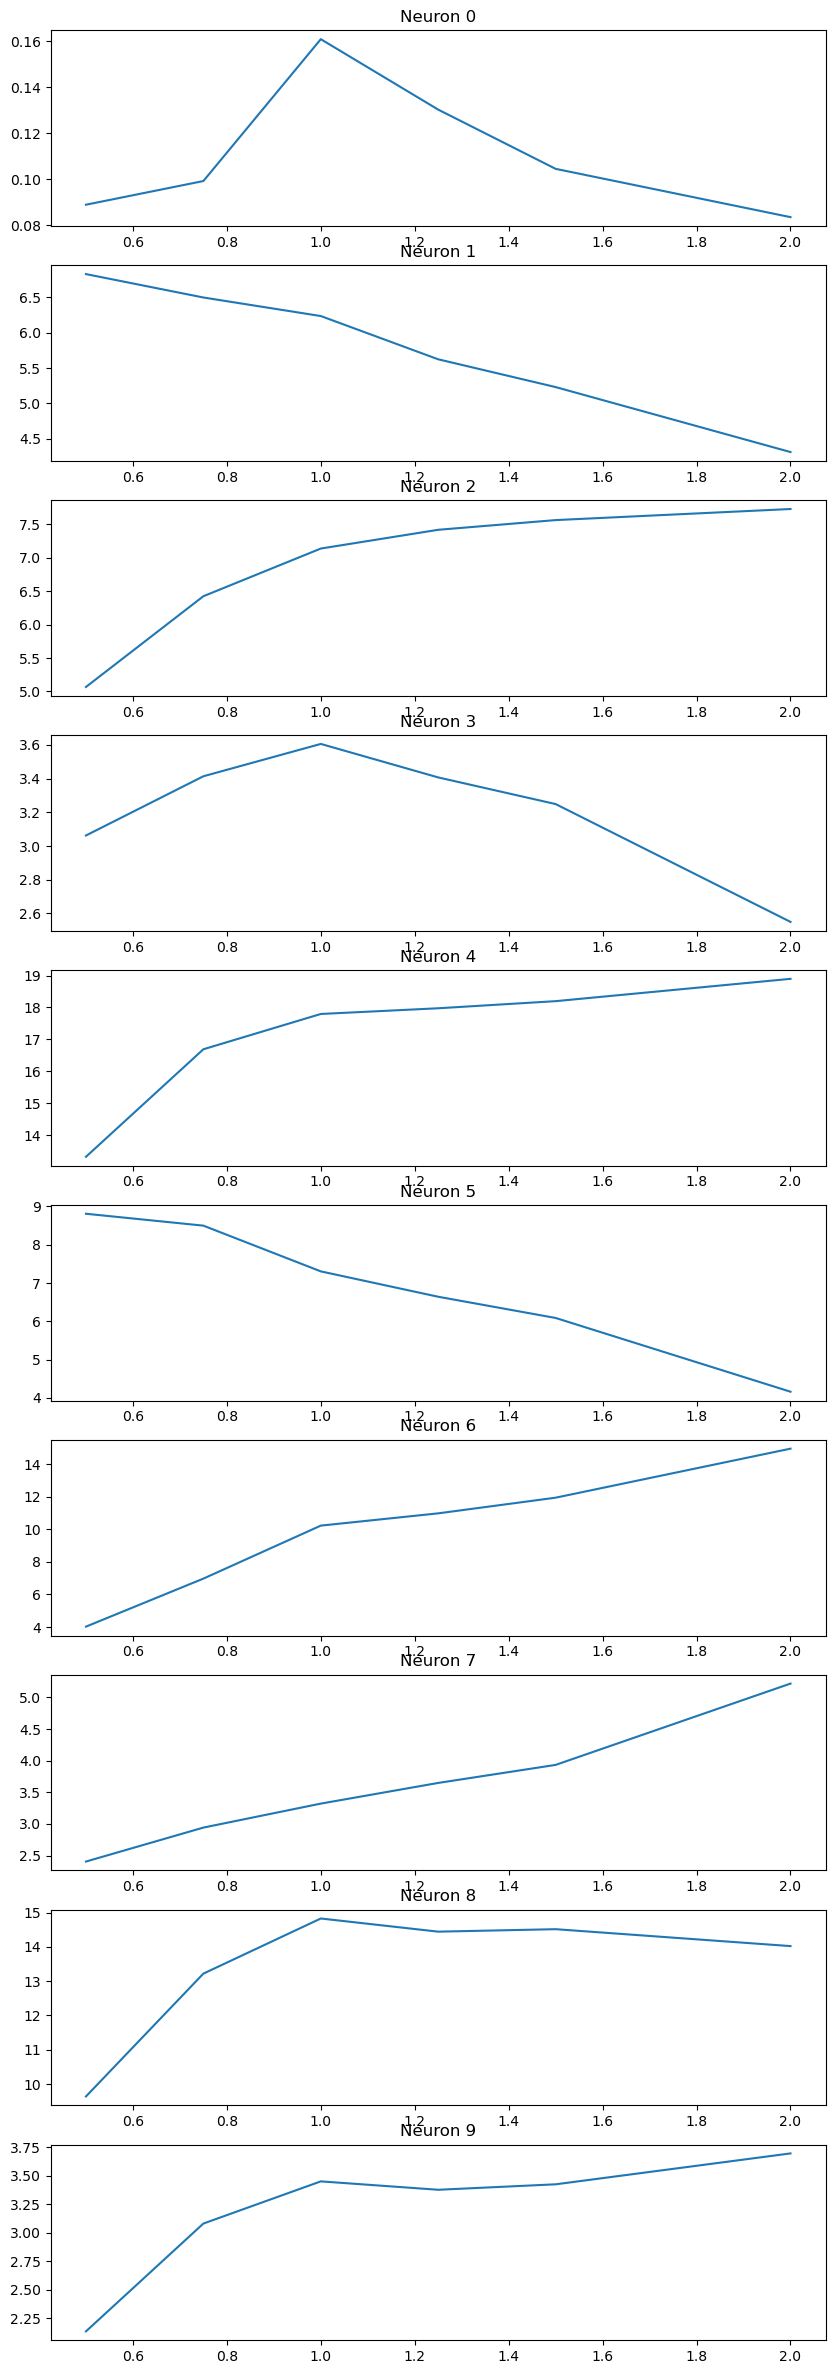

In [20]:
data = np.zeros((100,10,6))
targ = np.zeros((100,10))
sums_all = np.zeros((10,6))
i = 0
while i < len(all_embeddings[0]):
    j = 0
    while j < len(all_embeddings[0][0]):
        k = 0
        while k < len(all_embeddings):
            data[i][j][k] = all_embeddings[k][i][j]
            sums_all[j][k] += all_embeddings[k][i][j]
            k += 1
        targ[i][j] = targets[i]
        j += 1
    i += 1
#print(data, targ)

means_over_all = sums_all

# fig, axs = plt.subplots(10, figsize=(10, 30))
# i = 0
# for d in data:
#     j = 0
#     for c in d:
#         axs[j].plot(c)
#         j += 1
#     i += 1

fig, axs = plt.subplots(10, figsize=(10, 30))
i = 0
for m in means_over_all:
    axs[i].plot(shifts, m / 100)
    axs[i].title.set_text("Neuron " + str(i))
    i += 1